In [150]:
#Wiroon Siewsirithaworn CID: 276227
# Standard library imports
import os
import random
import string

# Data handling
import pandas as pd
import numpy as np

# NLP
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Visualization
import seaborn as sns

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# Deep Learning - Transformers and PyTorch
import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
from tqdm import tqdm

# Initialization of pre-trained models
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phoni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [151]:
# sns.__version__

## Data preprocessing

In [153]:
f_path = 'propaganda_dataset_v2/'

# f_path = '/content/drive/MyDrive/sussex/term02/NLP/coursework/propaganda_dataset_v2'
train_f ='propaganda_train.tsv'
val_f = 'propaganda_val.tsv'

train_path=os.path.join(f_path, train_f)
val_path = os.path.join(f_path, val_f)

In [154]:
train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
val_df = pd.read_csv(val_path, delimiter="\t", quotechar= '|')
train_df.head(10)

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
6,not_propaganda,A federal judge on Monday ordered U.S. immigra...
7,not_propaganda,<BOS> Kirstjen Nielsen (@SecNielsen) <EOS> Nov...
8,doubt,"As noted above, at this point literally every ..."
9,not_propaganda,Britain doesn't need more hate even just for a...


In [155]:
classes = list(train_df['label'].unique())
classes, len(classes)

(['not_propaganda',
  'flag_waving',
  'loaded_language',
  'doubt',
  'name_calling,labeling',
  'appeal_to_fear_prejudice',
  'repetition',
  'causal_oversimplification',
  'exaggeration,minimisation'],
 9)

In [156]:
## Helper function

In [157]:
def label_data(df_data, class_name='not_propaganda', multi_clf=False, bert_label_bin = False):
    """
    Labels the dataset based on the provided parameters to prepare it for machine learning models.
    This function can handle binary and multi-class labeling depending on the `multi_clf` and `bert_label_bin` flags.
    
    Args:
    df_data (DataFrame): Input data frame containing the text data.
    class_name (str): The class name for the 'not propaganda' class; used in binary classification.
    multi_clf (bool): Indicates if the classification is multi-class.
    bert_label_bin (bool): Indicates if the binary classification should be labeled with string names rather than integers.

    Returns:
    DataFrame or tuple: Modified DataFrame with labels or additionally, dictionaries mapping labels to ids and vice versa if multi-class.
    """
    labelled_data = []
    cols = df_data.columns

    if multi_clf == False and bert_label_bin == True:
        df_data['labelled'] = df_data[cols[0]].apply(lambda x: 'not_propaganda' if x == class_name else 'propaganda')

    elif multi_clf == False:
    # #not prop
        df_data['labelled'] = df_data[cols[0]].apply(lambda x: 0 if x == class_name else 1)


    elif multi_clf== True:
        label2id = {k : v for v, k in enumerate(list(sorted(df_data[cols[0]].unique())))}
        id2label = {v : k for v, k in enumerate(list(sorted(df_data[cols[0]].unique())))}


        df_data['labelled'] = df_data.label.map(lambda x: label2id[x.strip()])
        return label2id, id2label,df_data

    return df_data


def extract_st_ed_word(df_t):
    """
    Extracts a specific section of text from a DataFrame based on start and end tags, '<BOS>' and '<EOS>'.

    Args:
    df_t (DataFrame): DataFrame containing text data with embedded start and end tokens.

    Returns:
    DataFrame: New DataFrame with the extracted text sections.
    """
    st_token = '<BOS>'
    ed_token = '<EOS>'
    res = []

    for idx, row in df_t.iterrows():
        trimmed_string = row[df_t.columns[1]][row[df_t.columns[1]].find(st_token) + len(st_token):row[df_t.columns[1]].find(ed_token)].strip()
        res.append((row[df_t.columns[0]], trimmed_string, row[df_t.columns[2]]))

    return pd.DataFrame(res, columns =['category', 'tagged_in_context', 'label'])

def prepare_inputs(input1,label,device):
    """
    Prepares and sends model inputs and labels to the specified computing device (e.g., CPU, GPU).

    Args:
    input1 (dict): Dictionary containing 'input_ids' and 'attention_mask' from a tokenizer.
    label (Tensor): Tensor containing the labels.
    device (torch.device): The device tensors will be sent to.

    Returns:
    tuple: Tuple containing input ids, masks, and labels, all moved to the specified device.
    """
    label=label.to(device)
    mask=input1['attention_mask'].to(device)
    input_id=input1['input_ids'].squeeze(1).to(device)
    return (input_id,mask,label)

def plot_accuracy_comparison(acc1, acc2, Med1, Med2):
    """
    Plots a comparison of accuracy between two methods.

    Args:
    acc1 (float): Accuracy of the first method.
    acc2 (float): Accuracy of the second method.
    Med1 (str): Name of the first method.
    Med2 (str): Name of the second method.
    """
    # Method names
    methods = [Med1, Med2]

    # Accuracy values
    accuracies = [acc1, acc2]

    plt.bar(methods, accuracies, color=['blue', 'green'])

    # Adding labels and title
    plt.xlabel('Methods')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Accuracy Between Method 1 and Method 2')

    # Displaying the bar graph
    plt.ylim(0, 1)  # Setting y-axis limits
    plt.show()

def plot_heatmap(clf_report, t):
    """
    Plots a heatmap for a classification report.

    Args:
    clf_report (dict): Classification report as a dictionary.
    t (str): Title for the heatmap.
    """
    ax = plt.axes()
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax = ax)
    ax.set_title(t)
    plt.show()

batchsize = 2
def evaluate2(model, test_dataset):
    """
    Evaluates a model on a given test dataset, computing predictions and returning a classification report.

    Args:
    model (nn.Module): The neural network model to be evaluated.
    test_dataset (Dataset): The dataset to be tested.

    Returns:
    dict: Classification report as a dictionary.
    """
    model.eval()
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    # Lists to store all predictions and labels
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader):
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            predicted_labels = output.argmax(dim=1)

            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(test_label.cpu().numpy())

    return classification_report(all_labels, all_predictions, output_dict=True)




class Dataset_Multi(torch.utils.data.Dataset):
    """
    A custom PyTorch dataset for handling multi-class text classification data.
    """

    def __init__(self,df,column='tagged_in_context'):
        self.labels2=[labels2[l] for l in df['label']]
        self.texts=[tokenizer(text.lower(),padding='max_length',max_length=512,truncation=True,return_tensors="pt") for text in df[column]]

    def classes(self):
        return self.labels2

    def __len__(self):
        return len(self.labels2)

    def get_batch_labels(self,idx):
        return np.array(self.labels2[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


class BertMultiClassifier(nn.Module):
    """
    A BERT-based classifier for multi-class text classification.

    Inherits from:
    nn.Module: Base class for all neural network modules in PyTorch.
    """

    def __init__(self, dropout=0.5, num_classes=8):
        super(BertMultiClassifier, self).__init__()
        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):

        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        pooled_output=self.dropout(pooled_output)
        linear_output=self.linear(pooled_output)
        final_layer=self.relu(linear_output)
        # final_layer = F.Softmax(linear_output)

        # return final_layer
        return linear_output
    
def train(model, train_data,val_data,learning_rate,epochs):
    """
    Trains a model given training and validation data, with specified learning rate and number of epochs.

    Args:
    model (nn.Module): The model to be trained.
    train_data (Dataset): The training dataset.
    val_data (Dataset): The validation dataset.
    learning_rate (float): Learning rate for the optimizer.
    epochs (int): Number of epochs to train the model.

    Returns:
    None: The function is used to train the model and prints the training and validation metrics.
    """

    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(test_data,batch_size=2)

    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)

    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0
        model.train()
        for train_input,train_label in tqdm(train_dataloader):

            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

            output=model(input_id,mask)

            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()

            acc=(output.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                output=model(input_id,mask)

                batch_loss=criterion(output,val_label.long())

                total_loss_val+=batch_loss.item()

                acc=(output.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        
        

def plot_metrics(data1, data2, t1,t2):
    """
    Plots precision, recall, and F1-score for two different datasets using bar charts for comparison.

    Args:
    data1 (dict): Dictionary containing the metrics for the first dataset.
    data2 (dict): Dictionary containing the metrics for the second dataset.
    t1 (str): Title for the first plot.
    t2 (str): Title for the second plot.
    """
    # Filter out non-class keys like 'accuracy', 'macro avg', 'weighted avg' for both datasets
    class_keys1 = sorted([key for key in data1.keys() if key.isdigit()])
    class_keys2 = sorted([key for key in data2.keys() if key.isdigit()])
    metrics = ['precision', 'recall', 'f1-score']
    
    # Check if both datasets have the same classes for consistent comparison
    if class_keys1 != class_keys2:
        raise ValueError("Both data dictionaries must have the same classes.")
    
    # Prepare data for plotting
    n_groups = len(class_keys1)
    index = np.arange(n_groups)  # Arrange group positions
    bar_width = 0.25  # Width of the bars
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)  # Sharing y-axis for comparability
    
    # Plot each metric for all classes for data1
    for i, metric in enumerate(metrics):
        performance1 = [data1[key][metric] for key in class_keys1]
        ax1.bar(index + i * bar_width, performance1, bar_width, label=metric)
    
    # Plot each metric for all classes for data2
    for i, metric in enumerate(metrics):
        performance2 = [data2[key][metric] for key in class_keys2]
        ax2.bar(index + i * bar_width, performance2, bar_width, label=metric)

    # Label configuration for the first subplot
    ax1.set_ylabel('Score')
    ax1.set_title(t1)
    ax1.set_xticks(index + bar_width)
    ax1.set_xticklabels(class_keys1)
    ax1.set_ylim(0, 1)  # Assuming score ranges from 0 to 1
    ax1.legend()

    # Label configuration for the second subplot
    ax2.set_title(t2)
    ax2.set_xticks(index + bar_width)
    ax2.set_xticklabels(class_keys2)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    

def preprocess_text(text):
    """
    Preprocesses a text string: converts to lowercase, removes punctuation, and tokenizes.

    Args:
    text (str): The text to preprocess.

    Returns:
    list: List of tokens.
    """
    text = text.lower()  # convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = word_tokenize(text)  # tokenize
    return tokens


def document_vector(doc):
    """
    Computes the document vector by averaging the word vectors of the words in the document.

    Args:
    doc (list): List of words in the document.

    Returns:
    ndarray: Averaged word vector.
    """
    # ignore out-of-vocabulary words
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    return np.mean(w2v_model.wv[doc], axis=0) if doc else np.zeros(w2v_model.vector_size)



def remove_tag(df, tag):
    """
    Removes specified tags from a column in a DataFrame.

    Args:
    df (DataFrame): The DataFrame to modify.
    tag (str): The tag to remove from text.

    Returns:
    Series: Modified DataFrame column with tags removed.
    """
    df[tag] = df[tag].str.replace('<BOS>','', regex=False)
    df[tag] = df[tag].str.replace('<EOS>','', regex=False)
    return df[tag]


## Task 1 : propaganda binary classifier

### method 1 : BOW + Naive bayes

In [160]:
#label train data
training_data = label_data(train_df, 'not_propaganda')
training_data.head()
# training_data = extract_st_ed_word(training_data)
# training_data.head()

,label,tagged_in_context,labelled
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",0
1,not_propaganda,This declassification effort <BOS> won’t make ...,0
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",1
3,not_propaganda,“It looks like we’re capturing the demise of t...,0
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",0


In [161]:
#label test data
testing_data = label_data(val_df, 'not_propaganda')
# testing_data = extract_st_ed_word(testing_data)
testing_data.head()

,label,tagged_in_context,labelled
0,not_propaganda,"On average, between 300 and 600 infections are...",0
1,causal_oversimplification,Mostly because <BOS> the country would not las...,1
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,1
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,0
4,repetition,It must be exacted from him directly in order ...,1


In [162]:
training_data['tagged_in_context'] = remove_tag(training_data, 'tagged_in_context' )
testing_data['tagged_in_context'] = remove_tag(testing_data, 'tagged_in_context' )

In [163]:
training_data.head()

,label,tagged_in_context,labelled
0,not_propaganda,"No, he will not be confirmed.",0
1,not_propaganda,This declassification effort won’t make thing...,0
2,flag_waving,"""The Obama administration misled the American...",1
3,not_propaganda,“It looks like we’re capturing the demise of t...,0
4,not_propaganda,"Location: Westerville, Ohio",0


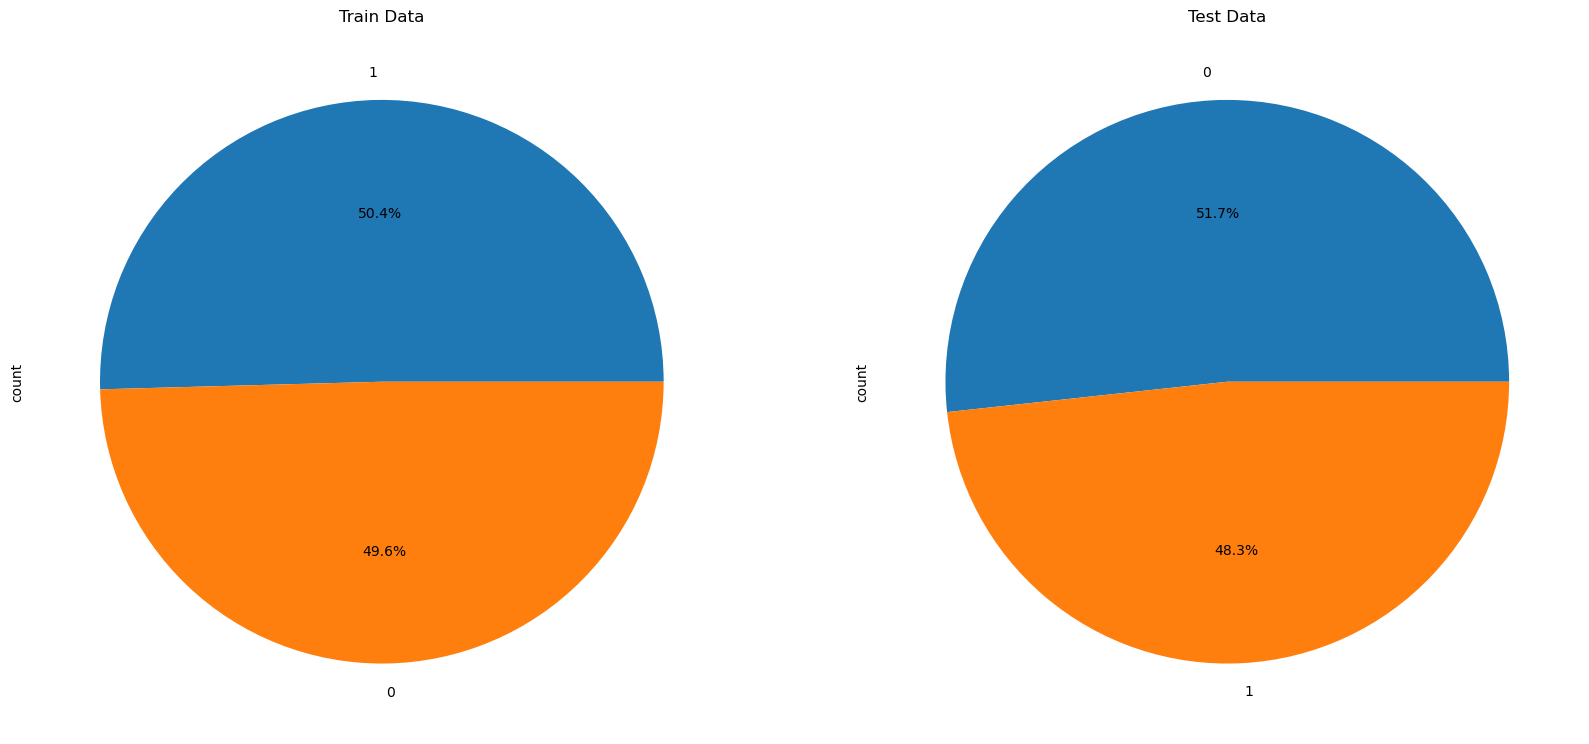

In [164]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

training_data_df = pd.DataFrame(training_data, columns=['tagged_in_context', 'labelled'])
testing_data_df = pd.DataFrame(testing_data, columns=['tagged_in_context', 'labelled'])

training_data_df['labelled'].value_counts().plot(kind='pie', ax=ax[0], autopct='%1.1f%%')
ax[0].set_title('Train Data')

testing_data_df['labelled'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%')
ax[1].set_title('Test Data')

plt.show()

In [165]:
training_dropcat = list(training_data.drop('label', axis = 1).to_records(index=False))
testing_dropcat = list(testing_data.drop('label', axis = 1).to_records(index=False))
training_dropcat[:5], testing_dropcat[:5]

([('No,  he  will not be confirmed. ', 0),
  ('This declassification effort  won’t make things any worse than they are for President Trump.  ', 0),
  ('"The Obama administration misled the  American people  and Congress because they were desperate to get a deal with Iran," said Sen. ', 1),
  ('“It looks like we’re capturing the demise of this dark vortex,  and  it’s different from what well-known studies led us to expect,” said Michael H. Wong of the University of California at Berkeley says. ', 0),
  (' Location: Westerville, Ohio  ', 0)],
 [('On average, between 300 and 600 infections are recorded every year among a population approaching 25 million people,  according to a UN estimate.  ', 0),
  ('Mostly because  the country would not last long without an outside high IQ elite to run the country . ', 1),
  ('Lyndon Johnson  gets Earl Warren and Sen. Richard Russel to join the Warren Commission by telling them that the assassination could lead to World War III . ', 1),
  (' You  may o

In [166]:
Xsents, Y = zip(*training_dropcat)
Xsents[:5], Y[:5],len(Xsents), len(Y)

(('No,  he  will not be confirmed. ',
  'This declassification effort  won’t make things any worse than they are for President Trump.  ',
  '"The Obama administration misled the  American people  and Congress because they were desperate to get a deal with Iran," said Sen. ',
  '“It looks like we’re capturing the demise of this dark vortex,  and  it’s different from what well-known studies led us to expect,” said Michael H. Wong of the University of California at Berkeley says. ',
  ' Location: Westerville, Ohio  '),
 (0, 0, 1, 0, 0),
 2560,
 2560)

In [167]:
vectorizer = CountVectorizer()
vectorizer.fit(Xsents)

# print(f'vocab{vectorizer.vocabulary_}')

Xvectors = vectorizer.transform(Xsents)
# print(Xvectors[0]), print(Y)

In [168]:
clf = MultinomialNB()
clf.fit(Xvectors, Y)

MultinomialNB()

In [169]:
Xsents_test, Y_test = zip(*testing_dropcat)
testVectors = vectorizer.transform(Xsents_test)

In [170]:
Xsents_test[:5]

('On average, between 300 and 600 infections are recorded every year among a population approaching 25 million people,  according to a UN estimate.  ',
 'Mostly because  the country would not last long without an outside high IQ elite to run the country . ',
 'Lyndon Johnson  gets Earl Warren and Sen. Richard Russel to join the Warren Commission by telling them that the assassination could lead to World War III . ',
 ' You  may opt out at anytime. ',
 'It must be exacted from him directly in order to vilify and humiliate him, so that Islam and its people may be exalted and the race of  infidels  brought low. ')

In [171]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [172]:
pipeline.fit(Xsents, Y)
y_pred = pipeline.predict(Xsents_test)

In [173]:
report_nb_bin_clf = classification_report(Y_test, y_pred, output_dict= True)

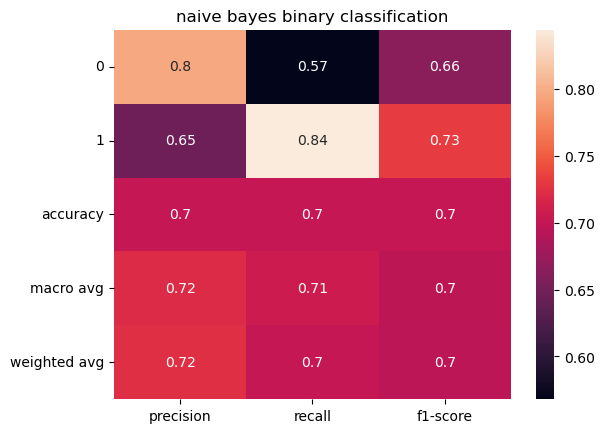

In [174]:
plot_heatmap(report_nb_bin_clf, 'naive bayes binary classification')

### method 2 BERT

In [176]:
training_data_df.head()

,tagged_in_context,labelled
0,"No, he will not be confirmed.",0
1,This declassification effort won’t make thing...,0
2,"""The Obama administration misled the American...",1
3,“It looks like we’re capturing the demise of t...,0
4,"Location: Westerville, Ohio",0


In [177]:
training_data_df = label_data(train_df, 'not_propaganda', bert_label_bin=True)
# training_data_df = extract_st_ed_word(training_data_df)
training_data_df = training_data_df.drop('label', axis = 1)
training_data_df.head()

,tagged_in_context,labelled
0,"No, he will not be confirmed.",not_propaganda
1,This declassification effort won’t make thing...,not_propaganda
2,"""The Obama administration misled the American...",propaganda
3,“It looks like we’re capturing the demise of t...,not_propaganda
4,"Location: Westerville, Ohio",not_propaganda


In [178]:
testing_data_df = label_data(val_df, 'not_propaganda', bert_label_bin=True)
# testing_data_df = extract_st_ed_word(testing_data_df)
testing_data_df = testing_data_df.drop('label', axis = 1)
testing_data_df.head()

,tagged_in_context,labelled
0,"On average, between 300 and 600 infections are...",not_propaganda
1,Mostly because the country would not last lon...,propaganda
2,Lyndon Johnson gets Earl Warren and Sen. Rich...,propaganda
3,You may opt out at anytime.,not_propaganda
4,It must be exacted from him directly in order ...,propaganda


In [179]:
training_data_df['tagged_in_context'] = remove_tag(training_data_df, 'tagged_in_context' )
testing_data_df['tagged_in_context'] = remove_tag(testing_data_df, 'tagged_in_context' )

In [180]:
training_data_df

,tagged_in_context,labelled
0,"No, he will not be confirmed.",not_propaganda
1,This declassification effort won’t make thing...,not_propaganda
2,"""The Obama administration misled the American...",propaganda
3,“It looks like we’re capturing the demise of t...,not_propaganda
4,"Location: Westerville, Ohio",not_propaganda
...,...,...
2555,We support and appreciate your business.”,not_propaganda
2556,International Atomic Energy Agency (IAEA) Dire...,not_propaganda
2557,What has been done: there has been work on for...,not_propaganda
2558,This is the law of gradualness not the gradua...,not_propaganda


In [181]:
testing_data_df

,tagged_in_context,labelled
0,"On average, between 300 and 600 infections are...",not_propaganda
1,Mostly because the country would not last lon...,propaganda
2,Lyndon Johnson gets Earl Warren and Sen. Rich...,propaganda
3,You may opt out at anytime.,not_propaganda
4,It must be exacted from him directly in order ...,propaganda
...,...,...
635,"NewsCatholic Church, Family, Marriage",not_propaganda
636,"Remember our saying, modern day fairy tales s...",not_propaganda
637,Why not open up to Iran with massive amounts...,not_propaganda
638,He also sang an Islamic State fight song and ...,propaganda


In [182]:
labellist=sorted(list(set(training_data_df['labelled'].unique()).union(set(testing_data_df['labelled'].unique()))))

labels={label:i for i,label in enumerate(labellist)}
labels

{'not_propaganda': 0, 'propaganda': 1}

In [183]:
ids_labels = {i: label for i, label in enumerate(labellist)}
ids_labels

{0: 'not_propaganda', 1: 'propaganda'}

In [184]:
training_data_df

,tagged_in_context,labelled
0,"No, he will not be confirmed.",not_propaganda
1,This declassification effort won’t make thing...,not_propaganda
2,"""The Obama administration misled the American...",propaganda
3,“It looks like we’re capturing the demise of t...,not_propaganda
4,"Location: Westerville, Ohio",not_propaganda
...,...,...
2555,We support and appreciate your business.”,not_propaganda
2556,International Atomic Energy Agency (IAEA) Dire...,not_propaganda
2557,What has been done: there has been work on for...,not_propaganda
2558,This is the law of gradualness not the gradua...,not_propaganda


In [185]:
import torch
import numpy as np
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self,df,column='tagged_in_context'):
        self.labels=[labels[label] for label in df['labelled']]
        self.texts=[tokenizer(text.lower(),padding='max_length',max_length=512,truncation=True,return_tensors="pt") for text in df[column]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


train_data=Dataset(training_data_df)
test_data=Dataset(testing_data_df)

In [186]:
# train_data.texts[0]

In [187]:
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")
print(device)

GPU acceleration enabled
cuda


In [188]:
train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=True)
bert=BertModel.from_pretrained('bert-base-uncased')
bert.to(device)

for train_input,train_label in train_dataloader:
    input_id,mask,label=prepare_inputs(train_input,train_label,device)
    output=bert(input_ids=input_id,attention_mask=mask,return_dict=False)
    break

print(input_id,mask,label)
print(len(output))
output[1]

tensor([[ 101, 6174, 3660,  ...,    0,    0,    0],
        [ 101, 4911, 2739,  ...,    0,    0,    0]], device='cuda:0') tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]], device='cuda:0') tensor([0, 1], device='cuda:0', dtype=torch.int32)
2


tensor([[-0.7819, -0.4767, -0.9419,  ..., -0.8525, -0.5120,  0.4220],
        [-0.8690, -0.4617, -0.5510,  ...,  0.1328, -0.6097,  0.7612]],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [189]:
import torch.nn as nn
from transformers import BertModel

class BertClassifierOptims(nn.Module):
    """
    A classifier built on top of a pre-trained BERT model with additional linear layers and dropout for regularization.
    This model is suitable for text classification tasks, utilizing BERT's embedding capabilities
    followed by a custom neural network structure to adapt to specific classification needs.

    Parameters:
    dropout (float): The dropout rate to use for regularization to prevent overfitting.
    num_classes (int): The number of output classes for the classifier.
    """

    def __init__(self, dropout=0.1, num_classes=2):
        super(BertClassifierOptims, self).__init__()
        # Initialize the BERT model, dropout layers, and linear layers.
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 256)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(256, num_classes)

    def forward(self, input_id, mask):
        """
        Define the forward pass of the classifier using input IDs and attention masks.

        Args:
        input_id (Tensor): The input IDs from the tokenizer.
        mask (Tensor): The attention masks specifying which parts of the input are actual data and which are padding.

        Returns:
        Tensor: The logits representing the model predictions for each class.
        """
        # Extract the pooled output from BERT, apply a series of transformations, and output the final class logits.
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = self.dropout(self.relu1(self.linear1(pooled_output)))
        x = self.dropout2(x)
        x = self.linear2(x)
        return x


In [190]:
len(labels.keys())

2

In [191]:
EPOCHS=4
# model=BertClassifier(num_classes=len(labels.keys()))
model = BertClassifierOptims(num_classes=len(labels.keys()))
model.to(device)
LR=1e-4

model.bert.requires_grad_(False) 

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [192]:
# train(model,train_data,test_data,LR,EPOCHS)

In [193]:
# output_dir="test_bin_bert_freeze_optim_test"
# torch.save(model,output_dir)

In [194]:
intput_dir = 'test_bin_bert_freeze_optim_test'
complete_model = torch.load(intput_dir)

In [195]:
report_bert_bin_clf =evaluate2(complete_model, test_data)

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:12<00:00, 24.88it/s]


In [196]:
report_bert_bin_clf

{'0': {'precision': 0.769811320754717,
  'recall': 0.6163141993957704,
  'f1-score': 0.6845637583892618,
  'support': 331.0},
 '1': {'precision': 0.6613333333333333,
  'recall': 0.8025889967637541,
  'f1-score': 0.7251461988304093,
  'support': 309.0},
 'accuracy': 0.70625,
 'macro avg': {'precision': 0.7155723270440252,
  'recall': 0.7094515980797622,
  'f1-score': 0.7048549786098355,
  'support': 640.0},
 'weighted avg': {'precision': 0.7174367924528302,
  'recall': 0.70625,
  'f1-score': 0.7041574679147533,
  'support': 640.0}}

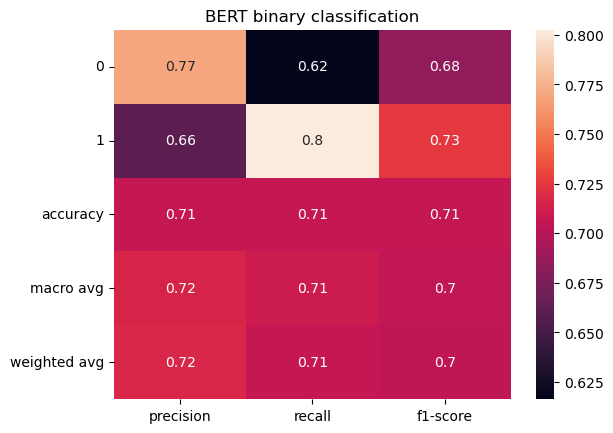

In [197]:
plot_heatmap(report_bert_bin_clf, 'BERT binary classification')

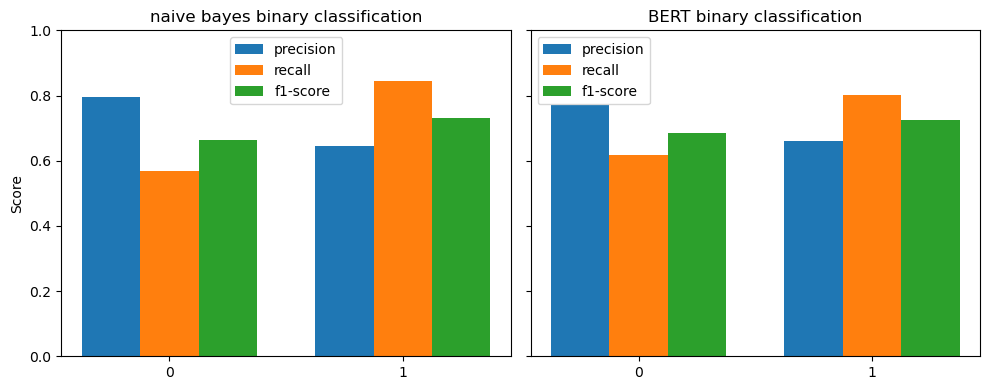

In [198]:
plot_metrics(report_nb_bin_clf,report_bert_bin_clf, 
             'naive bayes binary classification', 'BERT binary classification')

# Task 2: propaganda type detection

## Method 1 : BOW classifier

In [201]:
prop_df_train = pd.read_csv(train_path,delimiter="\t",quotechar='|')
prop_df_test = pd.read_csv(val_path, delimiter="\t", quotechar= '|')

prop_df_train = prop_df_train[prop_df_train['label'] != 'not_propaganda']
prop_df_train.reset_index(drop=True, inplace=True)

prop_df_test = prop_df_test[prop_df_test['label'] != 'not_propaganda']
prop_df_test.reset_index(drop=True, inplace=True)

In [202]:
prop_df_train

,label,tagged_in_context
0,flag_waving,"""The Obama administration misled the <BOS> Ame..."
1,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
2,doubt,"As noted above, at this point literally every ..."
3,"name_calling,labeling",His account was suspended for violating Twitte...
4,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...
...,...,...
1286,repetition,You might think that would have cured him of f...
1287,"exaggeration,minimisation",“I would like to take this opportunity to make...
1288,flag_waving,Trump To Jeff Sessions: Put An End to Russia P...
1289,causal_oversimplification,<BOS> Neither the Democrat leadership nor the ...


In [203]:
len(prop_df_train), len(prop_df_test)

(1291, 309)

In [204]:
prop_df_train.head()

,label,tagged_in_context
0,flag_waving,"""The Obama administration misled the <BOS> Ame..."
1,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
2,doubt,"As noted above, at this point literally every ..."
3,"name_calling,labeling",His account was suspended for violating Twitte...
4,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...


In [205]:
labels2, ids_labels2, multi_class_labelled_train = label_data(prop_df_train, multi_clf = True)
multi_class_labelled_train.head()

,label,tagged_in_context,labelled
0,flag_waving,"""The Obama administration misled the <BOS> Ame...",4
1,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",5
2,doubt,"As noted above, at this point literally every ...",2
3,"name_calling,labeling",His account was suspended for violating Twitte...,6
4,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,0


In [206]:
_,_,multi_class_labelled_test = label_data(prop_df_test, multi_clf = True)
multi_class_labelled_test.head()

,label,tagged_in_context,labelled
0,causal_oversimplification,Mostly because <BOS> the country would not las...,1
1,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,0
2,repetition,It must be exacted from him directly in order ...,7
3,"name_calling,labeling",Is it any wonder that priests and laity alike ...,6
4,loaded_language,Health workers have been asked to work with co...,5


In [207]:
multi_class_labelled_train.head()

,label,tagged_in_context,labelled
0,flag_waving,"""The Obama administration misled the <BOS> Ame...",4
1,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",5
2,doubt,"As noted above, at this point literally every ...",2
3,"name_calling,labeling",His account was suspended for violating Twitte...,6
4,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,0


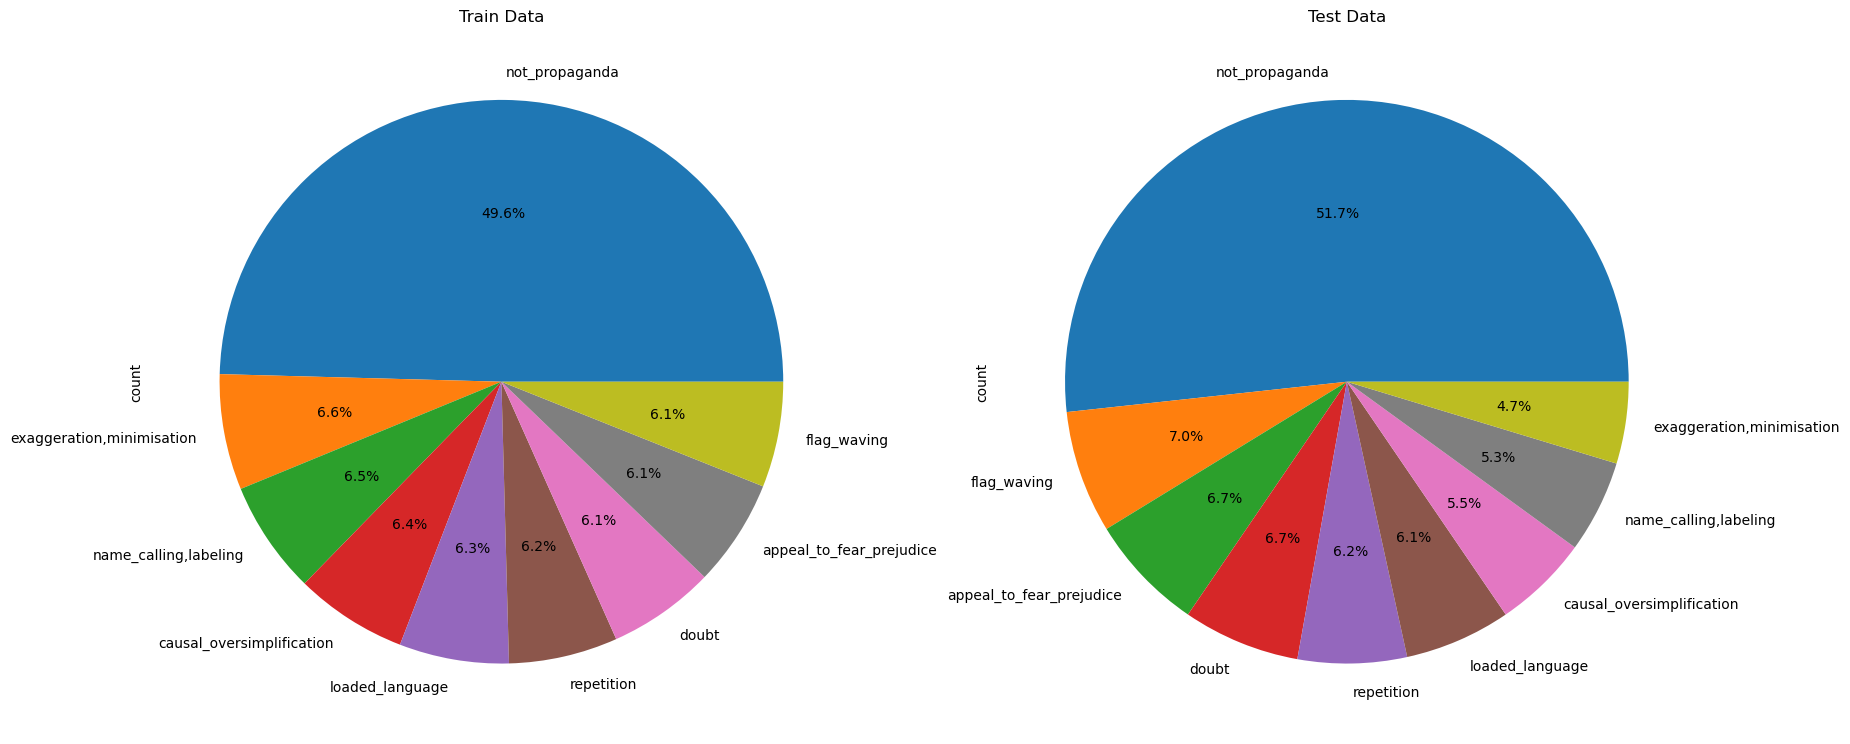

In [208]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

training_data_df = pd.DataFrame(training_data, columns=['tagged_in_context', 'label'])
testing_data_df = pd.DataFrame(testing_data, columns=['tagged_in_context', 'label'])

training_data_df['label'].value_counts().plot(kind='pie', ax=ax[0], autopct='%1.1f%%')
ax[0].set_title('Train Data')

testing_data_df['label'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%')
ax[1].set_title('Test Data')

plt.show()

In [209]:
prop_test_data = extract_st_ed_word(multi_class_labelled_test)
prop_test_data.head()

,category,tagged_in_context,label
0,causal_oversimplification,the country would not last long without an out...,1
1,appeal_to_fear_prejudice,gets Earl Warren and Sen. Richard Russel to jo...,0
2,repetition,infidels,7
3,"name_calling,labeling","the ""gay lifestyle",6
4,loaded_language,devastating communities,5


In [210]:
prop_train_data = extract_st_ed_word(multi_class_labelled_train)

prop_train_data.head()

,category,tagged_in_context,label
0,flag_waving,American people,4
1,loaded_language,annihilated,5
2,doubt,so-called evidence,2
3,"name_calling,labeling",hateful conduct,6
4,appeal_to_fear_prejudice,point to Iran’s positioning itself for more ag...,0


In [211]:
p_train = prop_train_data.drop(['category'], axis =1)
p_test = prop_test_data.drop(['category'], axis =1)

In [212]:
# p_train.head()

In [213]:
# p_test.head()

In [214]:
Xsents_train = list(p_train.tagged_in_context)
Xsents_test_ = list(p_test.tagged_in_context)

Y_train = list(p_train.label)
Y_test_ = list(p_test.label)

In [215]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [216]:
pipeline.fit(Xsents_train, Y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

In [217]:
y_pred_ = pipeline.predict(Xsents_test_)

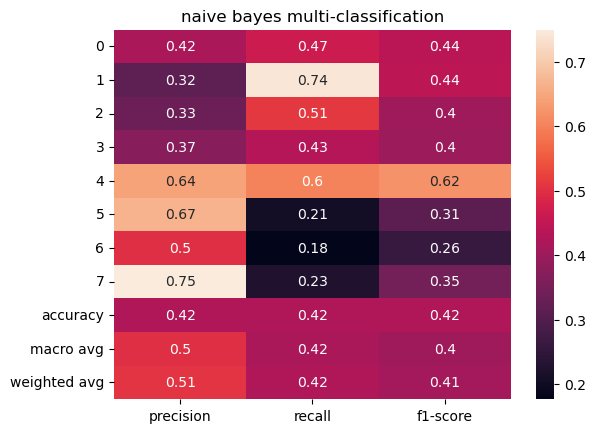

In [218]:
report_nb_mul_clf = classification_report(Y_test_, y_pred_, output_dict= True)
plot_heatmap(report_nb_mul_clf,'naive bayes multi-classification')


# Method 2 : BERT

In [220]:
p_train.head()

,tagged_in_context,label
0,American people,4
1,annihilated,5
2,so-called evidence,2
3,hateful conduct,6
4,point to Iran’s positioning itself for more ag...,0


In [221]:
p_test.head()

,tagged_in_context,label
0,the country would not last long without an out...,1
1,gets Earl Warren and Sen. Richard Russel to jo...,0
2,infidels,7
3,"the ""gay lifestyle",6
4,devastating communities,5


In [222]:
p_train_df = pd.DataFrame()
p_test_df = pd.DataFrame()

p_train_df['tagged_in_context'] = p_train['tagged_in_context']
p_test_df['tagged_in_context'] = p_test['tagged_in_context']

p_train_df['label'] = p_train['label'].map(ids_labels2)

p_test_df['label'] = p_test['label'].map(ids_labels2)

In [223]:
p_train_df.head()

,tagged_in_context,label
0,American people,flag_waving
1,annihilated,loaded_language
2,so-called evidence,doubt
3,hateful conduct,"name_calling,labeling"
4,point to Iran’s positioning itself for more ag...,appeal_to_fear_prejudice


In [224]:
p_test_df.head()

,tagged_in_context,label
0,the country would not last long without an out...,causal_oversimplification
1,gets Earl Warren and Sen. Richard Russel to jo...,appeal_to_fear_prejudice
2,infidels,repetition
3,"the ""gay lifestyle","name_calling,labeling"
4,devastating communities,loaded_language


In [225]:
labels2

{'appeal_to_fear_prejudice': 0,
 'causal_oversimplification': 1,
 'doubt': 2,
 'exaggeration,minimisation': 3,
 'flag_waving': 4,
 'loaded_language': 5,
 'name_calling,labeling': 6,
 'repetition': 7}

In [226]:
ids_labels2

{0: 'appeal_to_fear_prejudice',
 1: 'causal_oversimplification',
 2: 'doubt',
 3: 'exaggeration,minimisation',
 4: 'flag_waving',
 5: 'loaded_language',
 6: 'name_calling,labeling',
 7: 'repetition'}

In [227]:
train_data2 = Dataset_Multi(p_train_df)
test_data2 = Dataset_Multi(p_test_df)

In [228]:
device

device(type='cuda')

In [229]:
train_dataloader2 = torch.utils.data.DataLoader(train_data2, batch_size = 2, shuffle = True )
bert_model_multi = BertModel.from_pretrained('bert-base-uncased')

bert_model_multi.to(device)

for train_input, train_label in train_dataloader2:
    input_id,mask,label=prepare_inputs(train_input,train_label,device)
    output=bert_model_multi(input_ids=input_id,attention_mask=mask,return_dict=False)
    break

print(input_id,mask,label)
print(len(output))
output[1]

tensor([[ 101, 2076, 1996,  ...,    0,    0,    0],
        [ 101, 5432, 2008,  ...,    0,    0,    0]], device='cuda:0') tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]], device='cuda:0') tensor([3, 0], device='cuda:0', dtype=torch.int32)
2


tensor([[-0.8522, -0.3706, -0.0628,  ...,  0.2317, -0.6096,  0.8338],
        [-0.8647, -0.4742, -0.9684,  ..., -0.9136, -0.6455,  0.6531]],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [230]:
len(labels2)

8

In [231]:
class BertMultiClassifierOptims(nn.Module):
    def __init__(self, dropout=0.3, num_classes=8):  # Updated number of classes
        super(BertMultiClassifierOptims, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 256)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(256, num_classes)  # Output layer for 8 classes
    

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = self.dropout(self.relu1(self.linear1(pooled_output)))
        x = self.dropout2(x)
        x = self.linear2(x)
  
        return x

In [232]:
len(labels2.keys())

8

In [233]:
EPOCHS = 5
model2 = BertMultiClassifier(num_classes=len(labels2.keys()))
# model2 = BertMultiClassifierOptims(num_classes=len(labels2.keys()))

model2.to(device)
LR = 1e-5
# model2.bert.requires_grad_(False) 

In [234]:
# train(model2, train_data2, test_data2, LR, EPOCHS)

In [235]:
# output_dir="prop_types_bert_uncased_clf"
# # output_dir="multi_bert_optims"
# torch.save(model2,output_dir)

In [236]:
intput_dir = 'prop_types_bert_uncased_clf'
complete_model_2 = torch.load(intput_dir)

In [237]:
report_bert_mul_clf =evaluate2(complete_model_2, test_data2)

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:06<00:00, 23.10it/s]


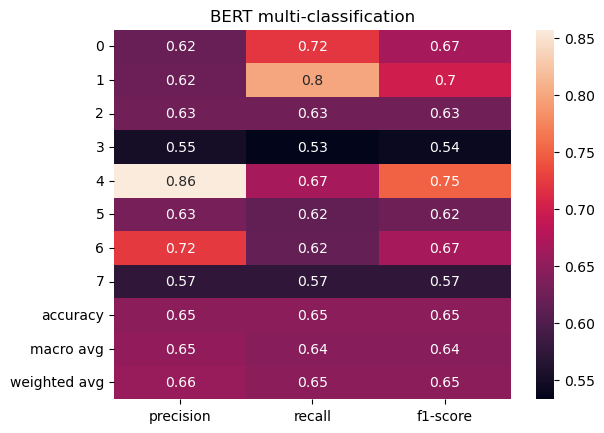

In [238]:
plot_heatmap(report_bert_mul_clf, 'BERT multi-classification')

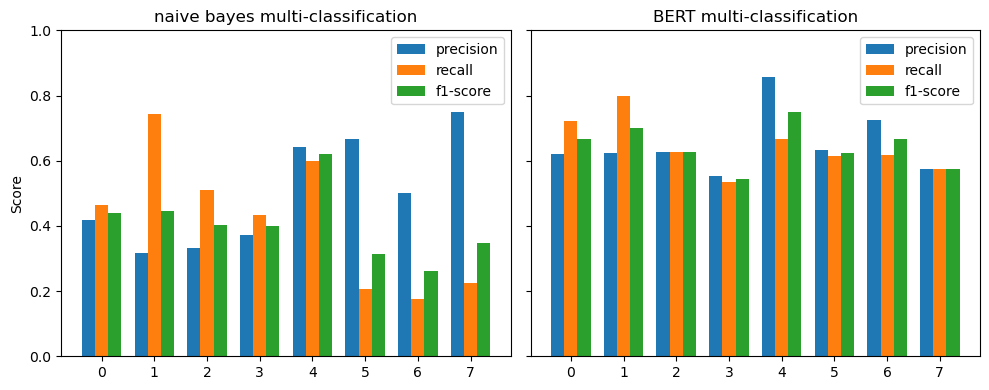

In [239]:
plot_metrics(report_nb_mul_clf, report_bert_mul_clf,
            'naive bayes multi-classification', 'BERT multi-classification')